In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
from math import log
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import time
import scipy
from sklearn.externals import joblib # create pickles for models, avoid retrains
import operator
from sklearn import linear_model
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix # classification evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score # regression evaluation
import pylab 
import xgboost as xgb
import gensim
import pyemd
# setup visual output configs
sns.set_style('darkgrid')
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 200
pd.set_option('display.width', 1000)
#import warnings
#warnings.filterwarnings('ignore')

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
for root, dirs, files in os.walk("./data", topdown=False):
    zip_files = glob.glob(root + '/*.zip')
    print("Unzipping...")
    print(zip_files)
    for zip_filename in zip_files:
        dir_name = os.path.splitext(zip_filename)[0]
        zip_handler = zipfile.ZipFile(zip_filename, "r")
        zip_handler.extractall(root)

Unzipping...
[]
Unzipping...
['./data/order_products__prior.csv.zip', './data/aisles.csv.zip', './data/orders.csv.zip', './data/products.csv.zip', './data/departments.csv.zip', './data/sample_submission.csv.zip', './data/order_products__train.csv.zip']


In [3]:
df_aisles = pd.read_csv('./data/aisles.csv')
df_products = pd.read_csv('./data/products.csv')
df_departments = pd.read_csv('./data/departments.csv')
df_sample_submission = pd.read_csv('./data/sample_submission.csv')
df_order_products__prior = pd.read_csv('./data/order_products__prior.csv')
df_order_products__train = pd.read_csv('./data/order_products__train.csv')
df_orders = pd.read_csv('./data/orders.csv')


In [4]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,38,1
4,5,Green Chile Anytime Sauce,5,13


In [25]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [26]:
df_sample_submission.head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [39]:
df_order_products__prior[df_order_products__prior.order_id == 221248].head()

,order_id,product_id,add_to_cart_order,reordered
2098027,221248,13176,1,1
2098028,221248,14992,2,1
2098029,221248,44422,3,0
2098030,221248,11520,4,0
2098031,221248,31506,5,0


In [35]:
df_order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [37]:
df_orders.sort_values(by="user_id")

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
10,1187899,1,train,11,4,8,14.0
9,2550362,1,prior,10,4,8,30.0
7,3108588,1,prior,8,1,14,14.0
6,550135,1,prior,7,1,9,20.0
8,2295261,1,prior,9,1,16,0.0
4,431534,1,prior,5,4,15,28.0
3,2254736,1,prior,4,4,7,29.0
2,473747,1,prior,3,3,12,21.0
1,2398795,1,prior,2,3,7,15.0


#### How many users?

In [71]:
df_orders.user_id.nunique()

206209

#### How many different products?

In [41]:
df_products.product_id.nunique()

49688

#### How many orders per weekday?

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


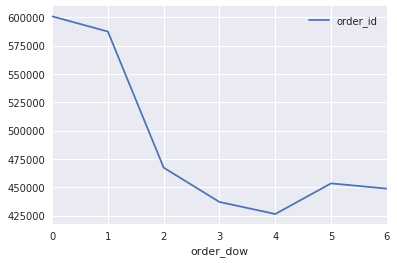

In [51]:
df_orders.groupby("order_dow").agg({"order_id": len}).plot()

#### How many orders per hour?

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


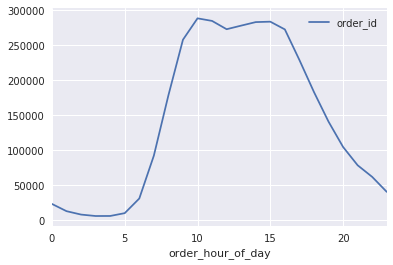

In [52]:
df_orders.groupby("order_hour_of_day").agg({"order_id": len}).plot()

#### Buying intervals plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e19d7abe0>]], dtype=object)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


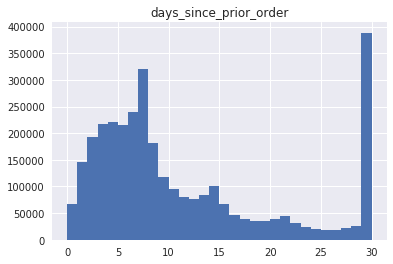

In [55]:
df_orders[["days_since_prior_order"]].dropna().hist(bins=30)

In [15]:
# Andrew curves
df_orders[df_orders["user_id"] == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


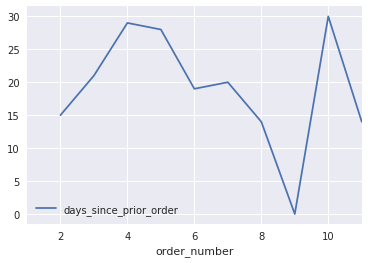

In [18]:
df_orders[df_orders["user_id"] == 1][["order_number", "days_since_prior_order"]].plot(x="order_number")

#### Histogram of total number of orders

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e19362da0>]], dtype=object)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


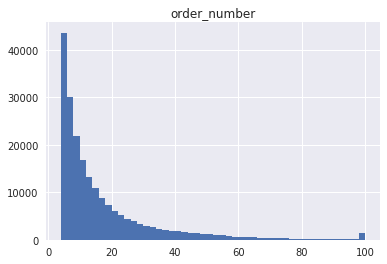

In [87]:
number_orders_per_user = df_orders[["order_number", "user_id"]].groupby("user_id").agg({"order_number": max})
number_orders_per_user.hist(bins=48)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e192a0208>]], dtype=object)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


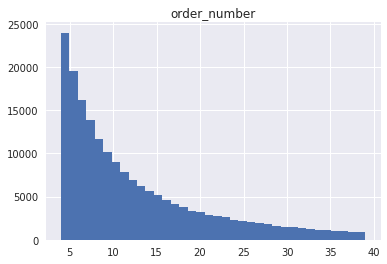

In [88]:
number_orders_per_user[number_orders_per_user.order_number < 40].hist(bins=36)

#### How many orders per user?

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0
5,2398795,1,prior,2,3,7,15.0,196.0,1.0,1.0
6,2398795,1,prior,2,3,7,15.0,10258.0,2.0,0.0
7,2398795,1,prior,2,3,7,15.0,12427.0,3.0,1.0
8,2398795,1,prior,2,3,7,15.0,13176.0,4.0,0.0
9,2398795,1,prior,2,3,7,15.0,26088.0,5.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b70d289b0>]], dtype=object)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


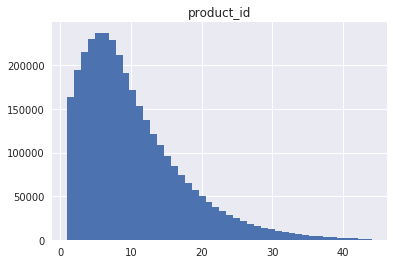

In [73]:
order_size = a.groupby("order_id").agg({"product_id": "count"})
order_size[order_size.product_id < 45].hist(bins=44)

#### How many products per order?

#### How does the buying interval time affect the order size?

#### Dummy model

In [ ]:
a = pd.concat([df_order_products__train, df_order_products__prior], axis=0)
tmp = pd.merge(df_orders, a, how='left', on=['order_id'])

In [83]:
tmp[(tmp.eval_set == "test")].shape

(75000, 10)

In [117]:
def best_sellers(user_id):
    order_size = tmp[(tmp.user_id == 3)].groupby("order_number").agg({"product_id":"count"})
    order_size = int(round(order_size[(~order_size.product_id.isnull()) & (order_size.product_id > 0)].mean()))
    top_products = tmp[(tmp.user_id == 3) & ((tmp.reordered > 0) | (tmp.eval_set == "test"))].groupby("product_id").agg({"product_id":"count"})
    top_products = top_products.sort_values(by="product_id", ascending=False)
    return top_products.iloc[:order_size].index.map(lambda x: int(x))

In [124]:
tmp_test = tmp[(tmp.eval_set == "test")].iloc[0:2]

In [125]:
tmp_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
384,2774568,3,test,13,5,15,11.0,NaN,NaN,NaN
403,329954,4,test,6,3,12,30.0,NaN,NaN,NaN


In [126]:
tmp_test["products"] = tmp_test["user_id"].apply(lambda x: best_sellers(x))

In [127]:
tmp_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,products
384,2774568,3,test,13,5,15,11.0,NaN,NaN,NaN,"[39190, 47766, 21903, 17668, 9387, 18599, 43961]"
403,329954,4,test,6,3,12,30.0,NaN,NaN,NaN,"[39190, 47766, 21903, 17668, 9387, 18599, 43961]"
